4: LES ARBRES DE DECISION: 
Nous allons tester maintenant les arbres de décisions. Dans ces arbres chaque noeud divise les observations en 2 branches en fonction d'une condition (par exemple alcohol<=12) et chaque feuille de l'arbre correspondra à une qualité égale à la moyenne de la qualité des observations présentes dans la feuille.
Une nouvelle observation x n'aura qu'à suivre le chemin de l'arbre en fonction des conditions des noeuds pour atterir dans une feuille. La prédiction sera alors la qualité de la feuille.

/home/henri/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(1074, 10)
(1074,)


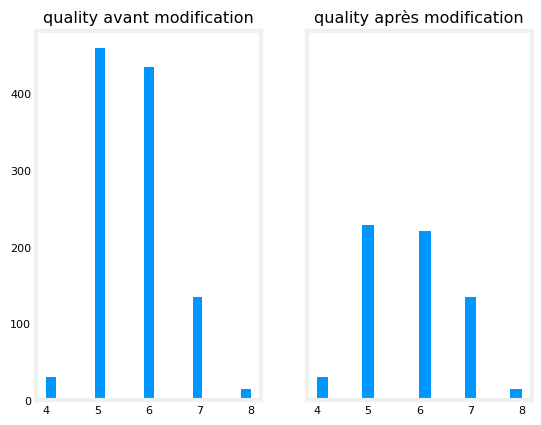

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
df = pd.read_csv('WineQT.csv')
import numpy as np
import matplotlib.pyplot as plt

def plot_hists(df):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
    for n in range(12):
        i = n % 3
        j = n % 4
        ax[i, j].hist(df.iloc[:, n], bins='auto')
        ax[i, j].set_xlabel(df.columns[n])

#On normalise : mettre entre 0 et 1
def normalize(df, property, parameter):
    df[property] = np.log(df[property] + parameter)


normalize(df, "fixed acidity", -2.3)
normalize(df, "sulphates", -0.24)
normalize(df, "total sulfur dioxide", 5)
normalize(df, "residual sugar", -1.1)
normalize(df, "chlorides", -0.005)
normalize(df, "volatile acidity", 2)
normalize(df, "free sulfur dioxide", 2)
#plot_hists(df)

standardized = (df - df.mean()) / df.std()
standardized = standardized[(np.abs(standardized) < 3).all(axis=1)]
rows = np.setdiff1d(list(df.index), list(standardized.index))
df.drop(index=rows, inplace=True)
#plot_hists(df)

import numpy as np
import matplotlib.pyplot as plt

#Préparation des données
y = df['quality']
X= [df['fixed acidity'],  df['volatile acidity']  ,df['citric acid']  ,df['residual sugar'],  df['chlorides'],df['free sulfur dioxide']  ,df['total sulfur dioxide'],  df['density']    ,df['pH'],  df['sulphates']]
X=np.transpose(np.array(X))
y=np.asarray(y)
print(X.shape)
print(y.shape)
X_features = ['fixed acidity',  'volatile acidity'  ,'citric acid'  ,'residual sugar',  'chlorides','free sulfur dioxide'  ,'total sulfur dioxide',  'density'    ,'pH',  'sulphates']
nb_feature=len(X_features)


#on supprime aleatoirement des valeurs de notes 5 et 6 (diviser par 2)
supp=[]
for i in range(len(y)):
    if y[i]==5 or y[i]==6:
        rand=random.random()
        if(rand>0.5):
            supp.append(i)
y2=np.delete(y,supp)

X2=np.delete(X,supp,0)

#Plot des modifications
fig,ax=plt.subplots(1,2,sharey=True)
ax[0].hist(y, bins='auto',label="quality")
ax[0].set_title("quality avant modification")

ax[1].hist(y2, bins='auto',label="quality")
ax[1].set_title("quality après modification")

#on créé les jeux de données
from sklearn.model_selection import train_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X2, y2, test_size=0.4, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

def zscore_normalize_features(X):
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)

 # normalize the original features
X_train, X_mu, X_sigma = zscore_normalize_features(X_train)
X_cv, X_mu, X_sigma = zscore_normalize_features(X_cv)
X_test, X_mu, X_sigma = zscore_normalize_features(X_test)

On va commencer par mettre en place un arbre de décision:

Pour cela :

- on commence à la racine avec tout le dataset qu'on veut split
- on teste les splits sur toutes les caractéristiques du vin avec un certain nombre de valeurs (ex: sulfate <= valeurn°12)
- on décide le split choisi en calculant l'utilité = le gain d'information qui dépend de la pureté des noeuds résultant du split
- on sépare le dataset en deux et on refait récursivement la même chose sur les 2 nouveaux noeuds.
- on s'arrête lorsque un noeud est totalement pure (=tous les vins de meme qualité), ou à une certaine profondeur

Code de l'arbre pour la prédiction du vin:


In [98]:
class ArbreBinaireVin:
    def __init__(self):
        self.qualite = 0
        self.split=0
        self.carac=0
        self.enfant_gauche = None
        self.enfant_droit = None


    def insert_gauche(self):
        self.enfant_gauche = ArbreBinaireVin()

    def insert_droit(self):
        self.enfant_droit = ArbreBinaireVin()

    def get_valeur(self):
        return self.valeur

    def get_gauche(self):
        return self.enfant_gauche

    def get_droit(self):
        return self.enfant_droit

    
    def get_predictionVin(self,x):

        if(x[self.carac]<=self.split):
            if(self.enfant_gauche==None):
                return self.qualite
            else:
                return self.enfant_gauche.get_predictionVin(x)
        else:
            if(self.enfant_droit==None):
                return self.qualite
            else:
                return self.enfant_droit.get_predictionVin(x)

    def affiche(self):
        print(self.carac,X_features[self.carac],self.split,self.qualite)
        if(self.enfant_gauche!=None):
            self.enfant_gauche.affiche()
        if(self.enfant_droit!=None):
            self.enfant_droit.affiche()

Code de la construction de l'arbre avec le dataset d'entrainement

In [103]:
#calcul de l'impureté d'un noeuf, pour savoir à quel point le noeud est pur (=les vins qui s'y trouvent ont la même qualité)
def gini_Impurity(y):
    """
    This function takes the splitted dataset, the indices we chose to split and returns the weighted entropy.
    """
    #on calcul le nombre de valeur par note de vin (0 à 8)
    tab_value=np.zeros(9)
    for loop in range(len(y)):
        tab_value[y[loop]]+=1
    #calcul de l'impureté
    impurity=1
    for loop in range(len(tab_value)):
        impurity-=(tab_value[loop]/sum(tab_value))**2
    return impurity
     
#split du noeud pour des valeurs continues (ex:split en fonction de la condition {X_alcohol<=12.355?})
def split_dataset_continue(X, node_indices, feature,t):

    left_indices = []
    right_indices = []
    for i in node_indices:
        if X[i,feature] <= t:
            left_indices.append(i)
        else:
            right_indices.append(i)
        
    return left_indices, right_indices 

#calcul du gain d'information = utilité d'un split, permet de choisir sur quelle condition on va split le noeud
def compute_information_gain_continue(X, y, node_indices, feature, t):
    
    left_indices, right_indices = split_dataset_continue(X, node_indices, feature,t)
    
    X_node, y_node = X[node_indices], y[node_indices]
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[right_indices], y[right_indices]
    
    information_gain = 0
    
    node_entropy = gini_Impurity(y_node)
    left_entropy = gini_Impurity(y_left)
    right_entropy = gini_Impurity(y_right)
    w_left = len(X_left) / len(X_node)
    w_right = len(X_right) / len(X_node)
    weighted_entropy = w_left * left_entropy + w_right * right_entropy
    information_gain = node_entropy - weighted_entropy
    
    return information_gain

#garder la meilleur condition pour le meilleur split
def get_best_split_continue(X, y, node_indices):   
    num_features = X.shape[1]
    
    best_feature = -1

    max_info_gain = 0
    tmax=0

    tab_max_feature=np.zeros(num_features)
    tab_min_feature=np.zeros(num_features)
    for loop in range(num_features):
        tab_max_feature[loop]=np.max(np.transpose(X)[loop])
        tab_min_feature[loop]=np.min(np.transpose(X)[loop])
    
    for feature in range(num_features):
        tab_t_feature=np.linspace(tab_min_feature[feature], tab_max_feature[feature], len(X)-1)
        
        for t in range(len(tab_t_feature)):
            info_gain = compute_information_gain_continue(X, y, node_indices, feature,tab_t_feature[t])

            if info_gain > max_info_gain:
                max_info_gain = info_gain
                best_feature = feature
                tmax=tab_t_feature[t]
   
    return best_feature,tmax,max_info_gain

#construction recursive de l'arbre de décision:
#on commence à la racine avec tout le dataset
#on teste les splits sur toutes les caractéristiques du vin avec un certain nombre de valeurs (ex: sulfate <= valeurn°12)
#on décide la condition choisie en calculant l'utilité = le gain d'information qui dépend de la pureté des noeuds résultant du split
#on sépare le dataset en deux et on refait récursivement la même chose sur les 2 nouveaux noeuds.
#on s'arrête lorsque un noeud est totalement pure (=tous les vins de meme qualité), ou à une certaine profondeur
def build_tree_recursive_continue(X, y, node_indices, branch_name, max_depth, current_depth, tree, arbreVin):

    if current_depth == max_depth:
        qualite_node=np.mean(y[node_indices])
        formatting = " "*current_depth + "-"*current_depth
        print(formatting, "%s leaf node with indices" % branch_name, node_indices)
        print(formatting,"note moyenne attribuée à la feuille :",qualite_node,"(",round(np.mean(y[node_indices])),")")

        arbreVin.qualite=round(qualite_node)

        return 0
   
    
    best_feature,tmax,max_info = get_best_split_continue(X, y, node_indices) 
    arbreVin.carac=best_feature
    arbreVin.split=tmax

    formatting = "-"*current_depth
    print("%s Depth %d, %s: Split on feature: %s <= %s, pour un gain de %s" % (formatting, current_depth, branch_name, X_features[best_feature], tmax,max_info))

    left_indices, right_indices = split_dataset_continue(X, node_indices, best_feature,tmax)
    tree.append((left_indices, right_indices, best_feature,tmax))
    
    if(len(left_indices)>1):
        arbreVin.insert_gauche()
        build_tree_recursive_continue(X, y, left_indices, "Left", max_depth, current_depth+1, tree,arbreVin.enfant_gauche)
    if(len(right_indices)>1):
        arbreVin.insert_droit()
        build_tree_recursive_continue(X, y, right_indices, "Right", max_depth, current_depth+1, tree,arbreVin.enfant_droit)
    return tree

Test de l'arbre de décision avec une profondeur max de 4:

In [107]:
tree = []
arbre = ArbreBinaireVin()
root_indices=list(range(0, len(X_train)))
build_tree_recursive_continue(X_train, y_train,root_indices, "Root", max_depth=4, current_depth=0, tree = tree, arbreVin=arbre);

/tmp/ipykernel_42683/506145069.py:13: RuntimeWarning: invalid value encountered in double_scalars
  impurity-=(tab_value[loop]/sum(tab_value))**2


 Depth 0, Root: Split on feature: sulphates <= -0.09272595611982037, pour un gain de 0.052469323042744875
- Depth 1, Left: Split on feature: total sulfur dioxide <= 0.853198588681813, pour un gain de 0.04485148373737924
-- Depth 2, Left: Split on feature: density <= 0.41867845114657687, pour un gain de 0.04332317923273732
--- Depth 3, Left: Split on feature: residual sugar <= 1.1300734780067812, pour un gain de 0.05027147181483804
    ---- Left leaf node with indices [2, 6, 13, 16, 17, 27, 33, 35, 37, 39, 43, 44, 46, 49, 56, 59, 63, 64, 70, 71, 73, 74, 76, 78, 79, 88, 93, 97, 103, 105, 110, 113, 118, 119, 120, 121, 125, 130, 136, 143, 150, 163, 164, 169, 173, 177, 179, 182, 183, 187, 188, 191, 194, 200, 209, 210, 215, 216, 219, 222, 225, 226, 228, 235, 236, 241, 243, 244, 248, 252, 255, 256, 260, 264, 266, 271, 272, 281, 283, 284, 286, 290, 291, 295, 306, 311, 314, 316, 320, 332, 335, 337, 344, 345, 355, 356, 365, 369, 374]
    ---- note moyenne attribuée à la feuille : 5.6363636363636

In [109]:
x=X_train[50]
print("vecteur x",x)
print("note prédite:",arbre.get_predictionVin(x))
print("vraie note :",y_train[50])

vecteur x [ 1.65989152 -0.56212655  1.29038469 -1.73235125  0.93061168  0.88161709
  0.30550152  0.39591505 -1.94880838  0.87331486]
note prédite: 7
vraie note : 7


In [ ]:
On a construit l'arbre de profondeur max 4, il ne reste plus qu'à faire passer notre jeu de test dedans.


In [113]:
def calcul_error(yhat,y_test):
   
    cost = 0.0
    m=len(y_test)
    for i in range(m):                                
        cost = cost + (y_test[i] - yhat[i])**2   #scalar
    cost = cost / (2 * m)                 #scalar    
    return cost

def predict_model(arbre,X,y):
    yhat=[]
    for loop in range(len(X)):
        yhat.append(arbre.get_predictionVin(X[loop]))

    sum=0
    for loop in range(len(yhat)):
        if(y[loop] == yhat[loop]):
            sum+=1
    print('Train Accuracy (%): ',(sum/len(yhat))*100)

    nn_test_error =calcul_error(yhat,y)

    print(f"Set Classification Error: {nn_test_error:.4f}")

In [116]:
predict_model(arbre,X_test,y_test)

Train Accuracy (%):  53.96825396825397
Set Classification Error: 0.3135


Nous obtenons 53% de bonnes prédictions sur le jeu de test.

Nous allons enfin mettre en place la random forest à l aide la bibliothèque sklearn et xgboost.
Random forest va créer plein d arbres de décision de ce type avec une part d aléatoire dans le choix des splits et choisir l arbre final grâce à un système de votes.

RANDOM FOREST POUR LA QUALITE DU VIN

In [41]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')

RANDOM_STATE = 55 ## We will pass it to every sklearn call so we ensure reproducibility

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test=le.fit_transform(y_test)

In [42]:
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = RANDOM_STATE)
xgb_model.fit(X_train,y_train, eval_set = [(X_test,y_test)], early_stopping_rounds = 10)

[0]	validation_0-mlogloss:1.76413
[1]	validation_0-mlogloss:1.74212
[2]	validation_0-mlogloss:1.74340
[3]	validation_0-mlogloss:1.72256


/home/henri/.local/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mlogloss:1.72616
[5]	validation_0-mlogloss:1.69494
[6]	validation_0-mlogloss:1.69315
[7]	validation_0-mlogloss:1.69298
[8]	validation_0-mlogloss:1.70397
[9]	validation_0-mlogloss:1.72146
[10]	validation_0-mlogloss:1.72980
[11]	validation_0-mlogloss:1.74967
[12]	validation_0-mlogloss:1.76279
[13]	validation_0-mlogloss:1.77983
[14]	validation_0-mlogloss:1.78464
[15]	validation_0-mlogloss:1.79472
[16]	validation_0-mlogloss:1.79150


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [43]:
xgb_model.best_iteration

7

In [44]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}")

print(xgb_model.classes_)
#print(xgb_model.classes_)

Metrics train:
	Accuracy score: 0.8093
Metrics test:
	Accuracy score: 0.8093
[0 1 2 3 4 5]


Le modèle random Forest nous permet d'obtenir sur le jeu de test 80% de précision, c'est le meilleur score obtenu.